In [176]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import os
import sys

## 1. Visualize the data and pre-processing

In [201]:
# load EMG data
EMG_file_names = ['DB8/S1_E1_A1.mat', 'DB8/S1_E1_A2', 'DB8/S1_E1_A3']

In [196]:
angle_all = []
emg_all = []
stimulus_all = []
repetition_all = []
extract_list = [3, 6, 8, 11, 14]

for ses_idx in range(3):
    emg_data = loadmat(EMG_file_names[ses_idx])
    glove = emg_data["glove"].copy()
    angle = glove[:, extract_list]
    emg = emg_data["emg"].copy()
    emg = emg[:,:]
    stimulus = emg_data["restimulus"][:]
    repetition = emg_data["rerepetition"][:]
    angle_all.append(angle)
    emg_all.append(emg)
    stimulus_all.append(stimulus)
    repetition_all.append(repetition)
    print(f'angle.shape={angle.shape}, emg={emg.shape}, stimulus={stimulus.shape}, repetition={repetition.shape}')

    n_stimuli = len(np.unique(stimulus)) - 1
    n_repetitions = len(np.unique(repetition)) - 1
    n_channels = emg.shape[1]
    print(f'---- How many types of movement are there? {n_stimuli}')
    print(f'---- How many repetitions are there? {n_repetitions}')
    print(f'---- How many channels are there? {n_channels}')

angle.shape=(2292526, 5), emg=(2292526, 16), stimulus=(2292526, 1), repetition=(2292526, 1)
---- How many types of movement are there? 9
---- How many repetitions are there? 10
---- How many channels are there? 16
angle.shape=(2313470, 5), emg=(2313470, 16), stimulus=(2313470, 1), repetition=(2313470, 1)
---- How many types of movement are there? 9
---- How many repetitions are there? 10
---- How many channels are there? 16
angle.shape=(529099, 5), emg=(529099, 16), stimulus=(529099, 1), repetition=(529099, 1)
---- How many types of movement are there? 9
---- How many repetitions are there? 2
---- How many channels are there? 16


Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

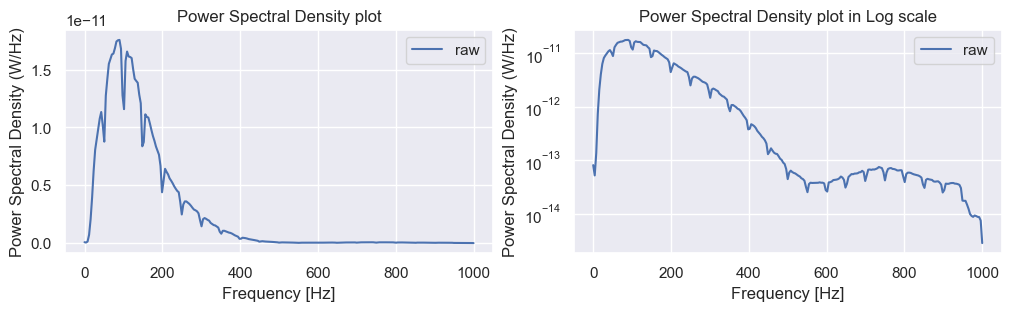

In [184]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.

freqs_pre, Pxx_pre = welch(emg_all[0][:, 8], fs=2000, nperseg=512)
plt.close("all")
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

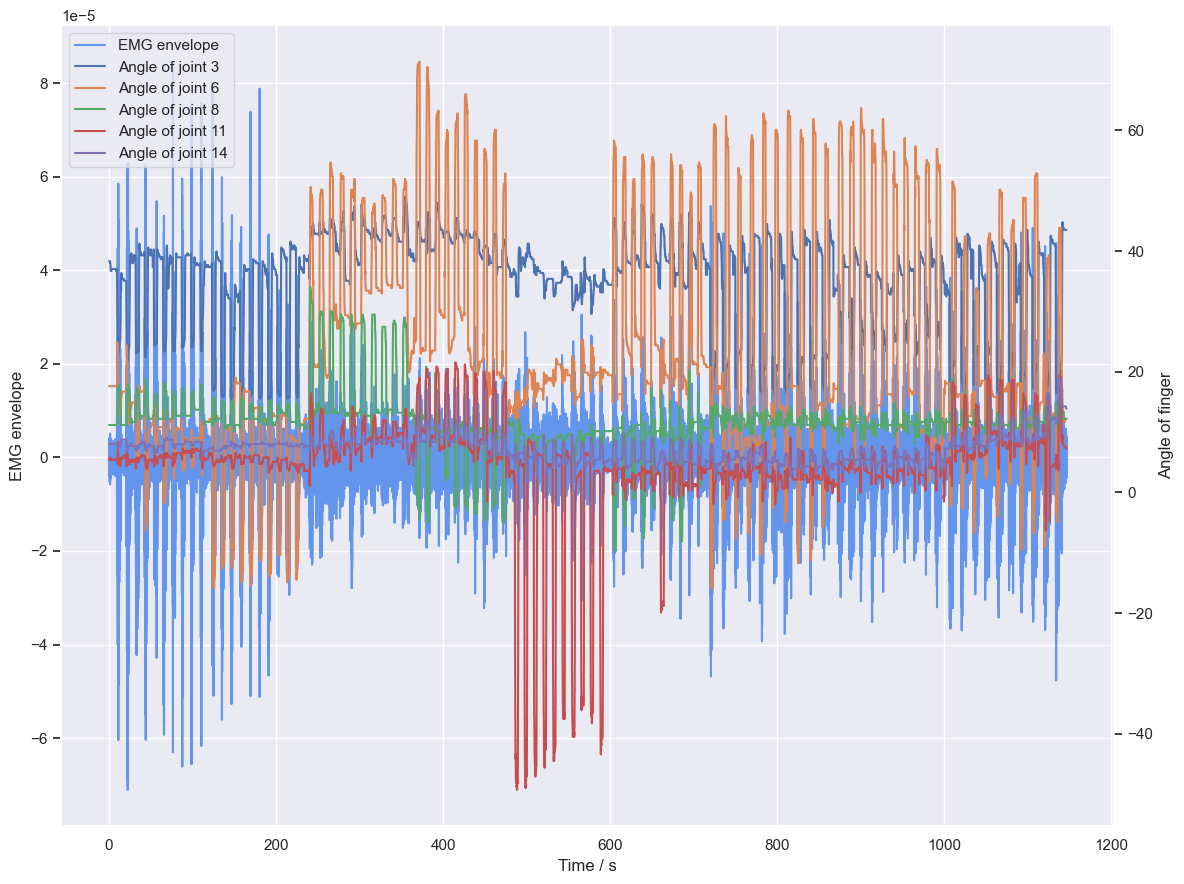

In [202]:
mov_mean_size = 50
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes_all = []
for ses_idx in range(3):
    EMG_envelopes = convolve1d(emg_all[ses_idx], weights=mov_mean_weights, axis=0)
    EMG_envelopes_all.append(EMG_envelopes)

fig, ax = plt.subplots(figsize=(12, 9))
n_samples = len(EMG_envelopes_all[0][:, 0])
fs = 2000
ax.plot(np.array(range(n_samples)) / fs, EMG_envelopes_all[0][:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time / s")
ax.grid(True)
# ax.set_ylim([0, 0.12])

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(np.array(range(n_samples)) / fs, angle_all[0][:, :], label=[f"Angle of joint {extract_list[i]}" for i in range(5)])
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)
# finger_angle_ax.set_ylim([50, 200])

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
# plt.xlim([0, 19000 / fs * 1000])
plt.tight_layout()

## 2. Perform sliding window

In [206]:
fs = 2000
emg_window_length_sec = 500e-3
incremental_window_length_sec = 100e-3

In [207]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """

    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len
    print(start_points, end_points)

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        assert(end_points[i] - start_points[i] == win_len)
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]


    return EMG_windows, Labels_window

In [208]:
EMG_train_windows, Labels_train_windows = extract_time_windows_regression(EMG_envelopes_all[0], angle_all[0], fs, emg_window_length_sec, incremental_window_length_sec)
EMG_val_windows, Labels_val_windows = extract_time_windows_regression(EMG_envelopes_all[1], angle_all[1], fs, emg_window_length_sec, incremental_window_length_sec)
EMG_test_windows, Labels_test_windows = extract_time_windows_regression(EMG_envelopes_all[2], angle_all[2], fs, emg_window_length_sec, incremental_window_length_sec)

print(f"EMG train windows shape: {EMG_train_windows.shape}, Train label windows shape: {Labels_train_windows.shape}")
print(f"EMG validation windows shape: {EMG_val_windows.shape}, Train label windows shape: {Labels_val_windows.shape}")
print(f"EMG test windows shape: {EMG_test_windows.shape},   Test label windows shape: {Labels_test_windows.shape}")

[      0     200     400 ... 2291000 2291200 2291400] [   1000    1200    1400 ... 2292000 2292200 2292400]
[      0     200     400 ... 2312000 2312200 2312400] [   1000    1200    1400 ... 2313000 2313200 2313400]
[     0    200    400 ... 527600 527800 528000] [  1000   1200   1400 ... 528600 528800 529000]
EMG train windows shape: (11458, 1000, 16), Train label windows shape: (11458, 1000, 5)
EMG validation windows shape: (11563, 1000, 16), Train label windows shape: (11563, 1000, 5)
EMG test windows shape: (2641, 1000, 16),   Test label windows shape: (2641, 1000, 5)


In [209]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, standard deviation, and max amplitude of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows,axis=1)
    EMG_std = np.std(EMG_windows,axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    EMG_psd = np.sum(welch(EMG_windows, axis=1)[1], axis=1)
    EMG_rms = np.sqrt(np.mean(EMG_windows**2, axis=1))
    EMG_wl = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    Labels_mean = np.mean(Labels_windows,axis=1)

    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude, EMG_psd, EMG_rms, EMG_wl), axis=1)
    return EMG_extracted_features, Labels_mean

In [210]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_val_windows,Labels_val_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG validation extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_val_extracted_features.shape, Labels_val_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (11458, 96), Fingler labels feature shape:(11458, 5)
EMG validation extracted features shape: (11563, 96), Fingler labels feature shape:(11563, 5)
EMG test extracted features shape: (2641, 96), Fingler labels feature shape:(2641, 5)


## 3. Extract a set of features, normalize them and visualize the correlation between them.

C:\Users\pengh\AppData\Local\Temp\ipykernel_25652\3937946354.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


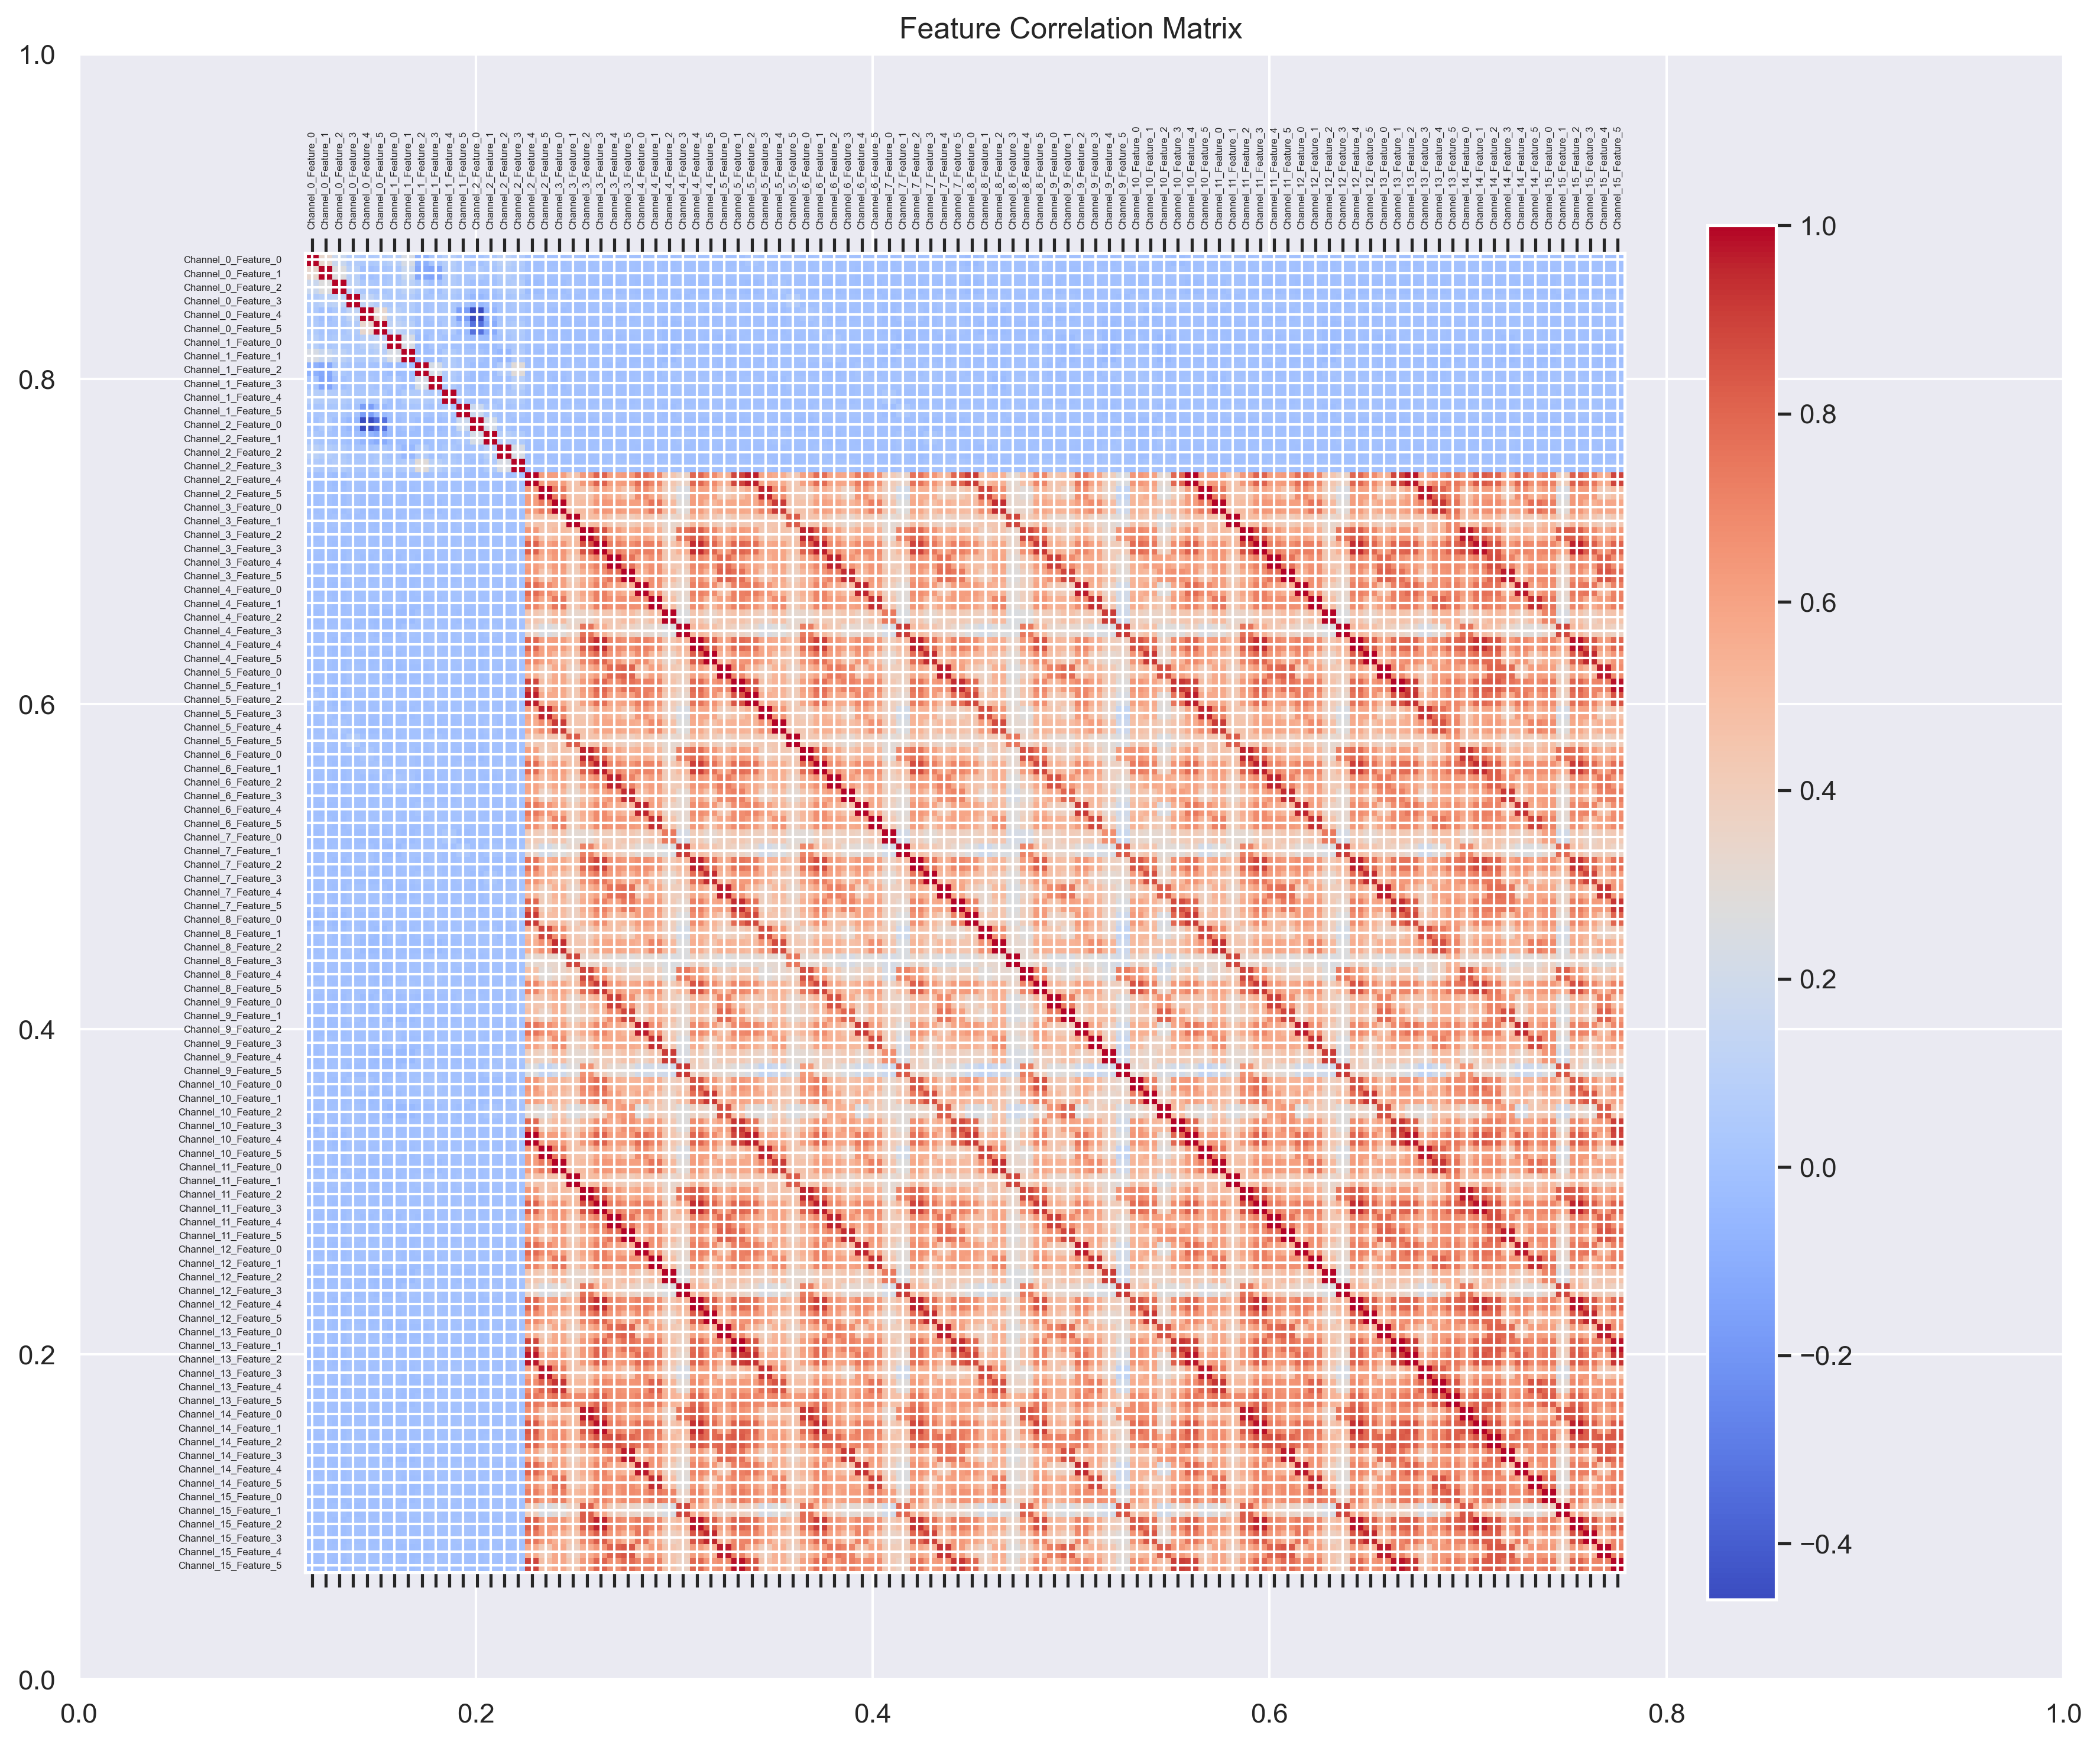

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设 features 的形状为 (num_windows, channels * num_features)
num_windows, total_features = EMG_train_extracted_features.shape
channels = 16  # 通道数
num_features = total_features // channels  # 每个通道的特征数

# 重新组织成 (num_windows, channels, num_features)
reshaped_features = EMG_train_extracted_features.reshape(num_windows, channels, num_features)

# 计算特征之间的相关性
# 将通道维度拼接，分析每个特征在所有通道上的相关性
feature_names = [f"Feature_{i}" for i in range(num_features)]
channel_names = [f"Channel_{ch}" for ch in range(channels)]

# 合并成一个 DataFrame，方便计算
flattened_features = reshaped_features.reshape(num_windows, -1)  # 形状 (num_windows, channels * num_features)
flattened_columns = [f"{channel_names[ch]}_{feature_names[f]}" for ch in range(channels) for f in range(num_features)]
df_features = pd.DataFrame(flattened_features, columns=flattened_columns)

# 计算相关性矩阵
correlation_matrix = df_features.corr()

# # 显示相关性矩阵
# print("特征之间的相关性矩阵：")
# print(correlation_matrix)

# 可视化相关性矩阵
plt.figure(figsize=(12, 10), dpi=300)
plt.title("Feature Correlation Matrix")
cax = plt.matshow(correlation_matrix, cmap="coolwarm", fignum=1)
plt.colorbar(cax)
plt.xticks(range(len(flattened_columns)), flattened_columns, rotation=90, fontsize=4)
plt.yticks(range(len(flattened_columns)), flattened_columns, fontsize=4)
plt.tight_layout()
plt.show()


## 4. Perform a regression on the kinematics.


In [216]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import GridSearchCV
#
# # Define the hyperparameter search space
# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "max_depth": [3, 4, 5],
#     "subsample": [0.8, 1.0],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2, 4],
# }
#
# regressor = GradientBoostingRegressor()
#
# grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
#
# grid_search.fit(EMG_train_extracted_features, Labels_train_mean[:, 0])
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

In [217]:
# regressor = MultiOutputRegressor(grid_search.best_estimator_)
regressor = MultiOutputRegressor(GradientBoostingRegressor())
regressor.fit(EMG_train_extracted_features, Labels_train_mean)
y_pred_val = regressor.predict(EMG_val_extracted_features)
y_pred_test = regressor.predict(EMG_test_extracted_features)

# Compute the mean squared error
GB_MSE_val = mean_squared_error(Labels_val_mean, y_pred_val)
GB_MSE_test = mean_squared_error(Labels_test_mean, y_pred_test)

print(f'Validation MSE of Gradient Boosting: {GB_MSE_val}')
print(f'Test MSE of Gradient Boosting: {GB_MSE_test}')

Validation MSE of Gradient Boosting: 37.87764866156877
Test MSE of Gradient Boosting: 27.29417494146953


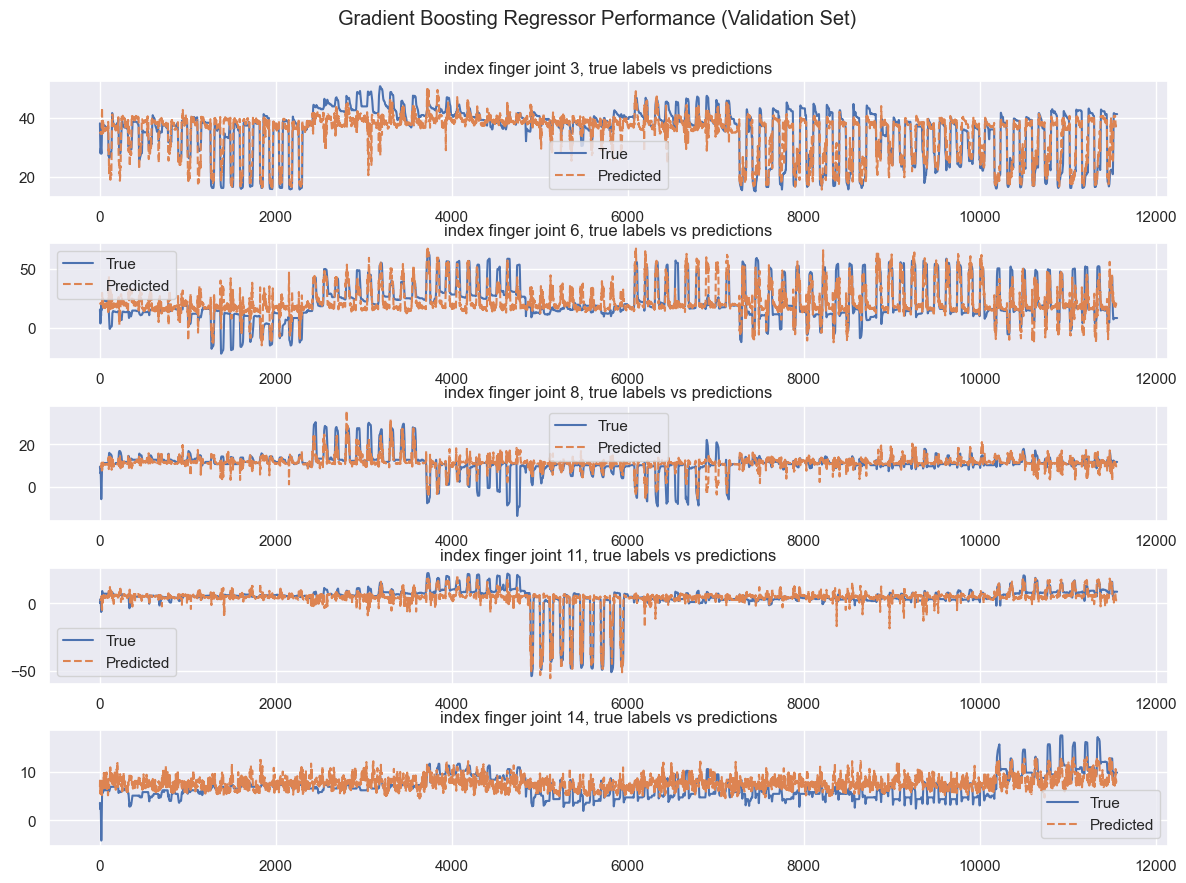

In [218]:
# Plot the true and predicted values for finger angle 5
plt.close("all")
fig, ax = plt.subplots(5, 1, figsize=(12, 9))
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Gradient Boosting Regressor Performance (Validation Set)")

for i in range(5):
    ax[i].plot(Labels_val_mean[:,i], label="True")
    ax[i].plot(y_pred_val[:, i], linestyle="--", label="Predicted")
    ax[i].set_title(f"index finger joint {extract_list[i]}, true labels vs predictions")
    ax[i].legend()

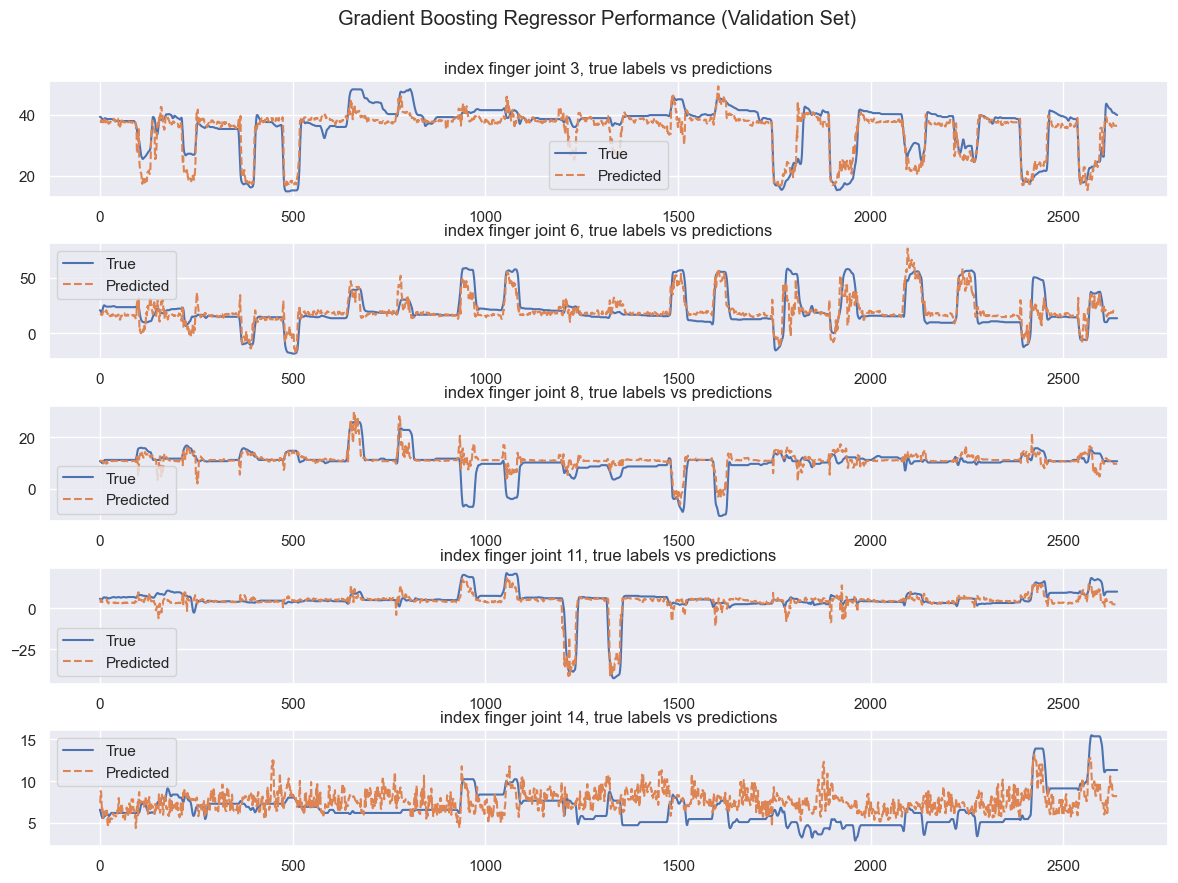

In [219]:
# Plot the true and predicted values for finger angle 5
plt.close("all")
fig, ax = plt.subplots(5, 1, figsize=(12, 9))
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Gradient Boosting Regressor Performance (Validation Set)")

for i in range(5):
    ax[i].plot(Labels_test_mean[:,i], label="True")
    ax[i].plot(y_pred_test[:, i], linestyle="--", label="Predicted")
    ax[i].set_title(f"index finger joint {extract_list[i]}, true labels vs predictions")
    ax[i].legend()